# Project Description

I work for Global Finance Cooporation that wishes to process its customer records for business purposes.
I've been advised that the existing systems in-place only exports to a CSV file,which is not an appropriate format for analysis.
I have therefore been given the following task:

1.To prepare the data for further analysis including representation changes,filtering and deriving new metrics for them.

2.Data Preprocessing.

3.Convert all flat structures into nested structures

4.My client informs me they have difficulty with errors in dependants column with some entries being empty.

5.My Client says there may be some issues with credit card entries and any customer with more than 10 years between start and end date need writing to seperate file and request that I write some function to help perform this.

6.I have been requested to calculate additional metrics to be used for customer ranking called 'Salary Commute'which will represent the salary a customer earns per mile of their commute.

# visualisation requirements

My client wishes to understand the data they have on their customer a bit more by use of visualisations and would like to:

1.Obtain data series for salary and age to calculate Mean salary and Mean age.

2.Visualise univariate plots of Age, dependents, age conditioned on marital status.

3.Plot the commuted distance against salary, Age against salary, Age against salary by dependents.

My client has finally requested the ability to save the plots I have produced.

# Data Processing

## 1. Reading in the data

In [1]:
import csv  # importing our csv Library

# loading each row in the csv and appending to a list
user_data = []  
with open('project.csv', 'r') as file:
    my_reader = csv.DictReader(file, delimiter=',') #read file as dictionary
    for row in  my_reader: #iterate over every line
        user_data.append(dict(row)) # add the dictionary gotten from each line to list of rows

In [2]:
user_data[:2]  #let's see how the data looks

[{'Address Street': '70 Lydia isle',
  'Address City': 'Lake Conor',
  'Address Postcode': 'S71 7XZ',
  'Age (Years)': '89',
  'Distance Commuted to Work (miles)': '0',
  'Employer Company': 'N/A',
  'Credit Card Start Date': '08/18',
  'Credit Card Expiry Date': '11/27',
  'Credit Card Number': '676373692463',
  'Credit Card CVV': '875',
  'Dependants': '3',
  'First Name': 'Kieran',
  'Bank IBAN': 'GB62PQKB71416034141571',
  'Last Name': 'Wilson',
  'Marital Status': 'married or civil partner',
  'Yearly Pension (GBP)': '7257',
  'Retired': 'True',
  'Yearly Salary (GBP)': '72838',
  'Sex': 'Male',
  'Vehicle Make': 'Hyundai',
  'Vehicle Model': 'Bonneville',
  'Vehicle Year': '2009',
  'Vehicle Type': 'Pickup'},
 {'Address Street': '00 Wheeler wells',
  'Address City': 'Chapmanton',
  'Address Postcode': 'L2 7BT',
  'Age (Years)': '46',
  'Distance Commuted to Work (miles)': '13.72',
  'Employer Company': 'Begum-Williams',
  'Credit Card Start Date': '08/12',
  'Credit Card Expiry D

## 2. Converting from flat to nested structure

In [3]:
# categories and their column names
vehicle_cols = ['Vehicle Make','Vehicle Model','Vehicle Year', 'Vehicle Type']
credit_cols = ['Credit Card Start Date','Credit Card Expiry Date','Credit Card Number', 'Credit Card CVV','Bank IBAN', 'Dependants']
address_cols = ['Address Street', 'Address City', 'Address Postcode']

In [4]:
# a function to make the conversion into nesting easier
def nest(user,column_names, category):
    user[category] = { your_key: user[your_key] for your_key in column_names }
    for col in column_names:
        user.pop(col, None) # remove key from dictionary
        return user # return nested dictionary

In [5]:
nested_data = [] #create empty list to hold nested_data

for user in user_data : #loop through every dictionary
    user_copy = user.copy() #creating a copy of original dictionary
    nested_dict = nest(user_copy, vehicle_cols, 'Vehicle') #nesting the vehicle cols
    nested_dict = nest(nested_dict.copy(),credit_cols, 'Credit Card') # nesting the Credit Card cols
    nested_dict = nest(nested_dict.copy(),address_cols, 'Address') #  nesting the address columns
    nested_data.append(nested_dict) #add to previous list of dictionaries

## 3. Identifying problematic rows

In [6]:
faulty_rows = [] # empty list to hold faulty rows

for num,user in enumerate (nested_data): #loop through every dictionary in user data
    if user['Credit Card']['Dependants'] in [''," "]: # check if dependant value is empty
        faulty_rows.append(num) #add index of row to list of faulty_rows
print(faulty_rows)

[21, 109, 179, 205, 270, 272, 274, 358, 460, 468, 579, 636, 679, 725, 822, 865, 917, 931, 983]


## 4. Writing records into 'processed.json'

In [7]:
import json #importing the json library
with open('processed.json', 'w') as fout :
    json.dump(nested_data , fout)

## 5. Creating **retired json** and **employed.json**

In [8]:
retired = [] #empty list to hold dictionaries of retired users
employed = [] #empty list to hold dictionaries of employed users

for user in nested_data : #loop through every user
    if user['Retired'] == 'True' : # checks if user is retired
        retired.append(user) # adds to list of retired users
    if user ['Employer Company'] != 'Nan' : # checks if user is employed
        employed.append(user) # adds to list of employed users

In [9]:

# writing list of retired users into retired.json
with open('retired.json', 'w') as fout :
    json.dump(retired , fout)

# writing list of employed users into employed.json
with open('employed.json', 'w') as fout:
    json.dump(employed , fout)

## 6. Creating **remove_ccard.json**

In [10]:
#selecting rows where months difference  > 120
remove_card = []

for user in nested_data :
  #extract start year, start_month, end year and end month of debit card
    start_month, start_year = [int(val) for val in str.split(user['Credit Card']['Credit Card Start Date'],'/')]
    exp_month, exp_year = [int(val) for val in str.split(user['Credit Card']['Credit Card Expiry Date'], '/')]
  # calculate number of months between start date and end date
    start_months_from_00 = start_year *12 + start_month
    exp_months_from_00 = exp_year * 12 + exp_month 

    if exp_months_from_00 - start_months_from_00 > 120 : #checks if end - start greater than 120 months 
        remove_card.append(user) # add to list of card to be removed

In [11]:
with open('remove_ccard.json', 'w') as fout :
    json.dump(remove_card , fout)

## 7. Creating **commute.json**

### Reading in **processed.json**

In [12]:

# write to json
with open('processed.json') as f:
    processed = json.load(f)

### 7a. Calculating new metric, **Salary-Commute**

In [13]:
salary_commute= processed.copy()

for num,user in enumerate (processed) :
    if float(user['Distance Commuted to Work (miles)']) <= 1 : # checks if distance commuted is less than 1 mile
        salary_commute[num]['Salary-Commute'] = user['Yearly Salary (GBP)'] #salary commute = salary
    else : # if distance more than 1 mile
     # salary commute = salary/ distance 
        salary_commute[num][ 'Salary-Commute'] = float(user ['Yearly Salary (GBP)'])/float(user['Distance Commuted to Work (miles)'])

### 7b. Sorting the records by new metric in ascending order

In [14]:

# function to sort by salary commute
def sort_salary_commute (user) :
    return float(user['Salary-Commute'])
# sort salary commute
salary_commute.sort(key=sort_salary_commute)

### 7c. Writing sorted records to JSON

In [15]:
with open('commute.json', 'w') as fout :
    json.dump(salary_commute , fout)

# Data visualization

## Loading in the data

In [16]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('project.csv') # load in the data 
df.head() # show first five rows

,Address Street,Address City,Address Postcode,Age (Years),Distance Commuted to Work (miles),Employer Company,Credit Card Start Date,Credit Card Expiry Date,Credit Card Number,Credit Card CVV,...,Last Name,Marital Status,Yearly Pension (GBP),Retired,Yearly Salary (GBP),Sex,Vehicle Make,Vehicle Model,Vehicle Year,Vehicle Type
0,70 Lydia isle,Lake Conor,S71 7XZ,89,0.00,NaN,08/18,11/27,676373692463,875,...,Wilson,married or civil partner,7257,True,72838,Male,Hyundai,Bonneville,2009,Pickup
1,00 Wheeler wells,Chapmanton,L2 7BT,46,13.72,Begum-Williams,08/12,11/26,4529436854129855,583,...,Thomas,married or civil partner,0,False,54016,Male,Nissan,ATS,1996,Coupe
2,Studio 33K Joel walk,Randallborough,ME3N 1GH,22,16.02,Hill-Wright,11/19,07/27,4091726363083888495,422,...,Jones,married or civil partner,0,False,68049,Male,GMC,Achieva,2015,"Convertible, Coupe"
3,Studio 46S Bethany lights,East Reece,E10 9RJ,56,19.35,Green LLC,10/17,04/18,4671332769487632633,669,...,Shaw,married or civil partner,0,False,91337,Male,Scion,F150 SuperCrew Cab,1994,Pickup
4,Flat 3 Christine views,Fletcherstad,WS2 9SN,57,5.94,"Hill, Evans and Harrison",04/19,11/27,2245094149128526,659,...,O'Brien,married or civil partner,0,False,18446,Female,Buick,Outback,2020,SUV


## 1. Calculating the mean and median of Salary and Age, respectively

In [17]:
mean_salary = df['Yearly Salary (GBP)'].mean() # calculate mean yearly salary
median_age = df['Age (Years)'].median() # calculate median age 
print(f'Mean salary is {mean_salary} and Median_age is {median_age}')

Mean salary is 57814.078 and Median_age is 54.0


## 2. Univariate plots

## 2a. Plotting **age** with bin_width of 5

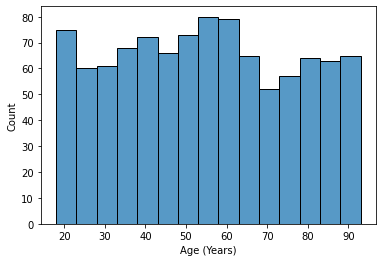

In [18]:
age_plot_binwidth_5 = sns.histplot( df['Age (Years)'], binwidth = 5)

## 2b. Plot of **Dependants**

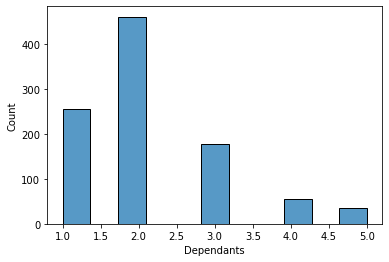

In [19]:
dependants_plot = sns.histplot( df['Dependants'])

## 2c. Plot of age, conditioned on Marital Status

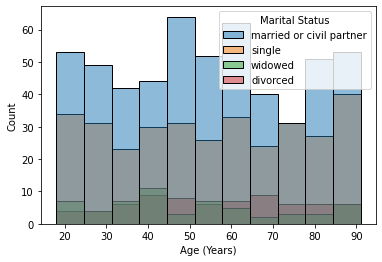

In [20]:
age_plot_by_marital_status = sns.histplot( df, x ='Age  (Years)', hue = 'Marital Status')

## 3. Multivariate Plots

## 3a. Plot of Distance Commuted against Salary

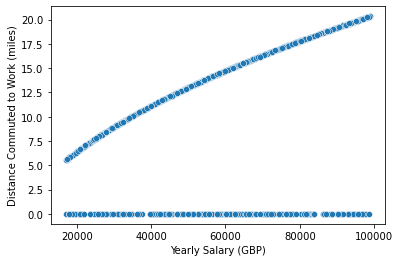

In [21]:
distance_commuted_against_salary = sns.scatterplot(data= df, x = 'Yearly Salary (GBP)', y = 'Distance Commuted to Work (miles)')

## 3b. Plot of Age against Salary

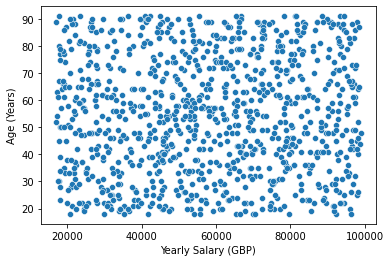

In [22]:
age_against_salary = sns.scatterplot(data= df, x = 'Yearly Salary (GBP)', y = 'Age (Years)')

## 3c. Plot of Age against Salary, conditioned on dependants

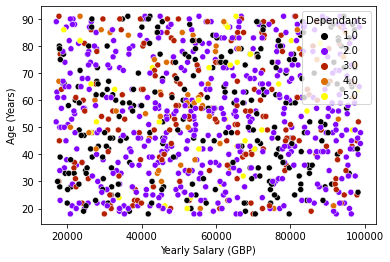

In [23]:
age_against_salary_by_dependants = sns.scatterplot(data= df, x = 'Yearly Salary (GBP)', y = 'Age (Years)', hue = 'Dependants', palette='gnuplot')

## 4. Saving plots

In [24]:
age_plot_binwidth_5.get_figure().savefig('age_plot_binwidth_5.png')
dependants_plot.get_figure().savefig('dependants_plot.png')
age_plot_by_marital_status.get_figure().savefig('age_plot_by_marital_status.png')
distance_commuted_against_salary.get_figure().savefig('distance_commuted_against_salary.png')
age_against_salary.get_figure().savefig('age_against_salary.png')
age_against_salary_by_dependants.get_figure().savefig('age_against_salary_by_dependants.png')

Overall, the project successfully transformed and enriched the customer data, providing the client with more accurate, insightful, and actionable information. The visualizations and new metrics facilitated a better understanding of their customer base, supporting data-driven business decisions.